# Single Glomerular Stimulation Detection Training - Single Mouse

*_This code contains may artifacts from prior iterations and therefore isn't the most efficient._

This code produces a plot which shows all training sessions for a single mouse. Specifically, the plot produced shows the mouse's detection rate accross multiple sessions until the task is learned.

### Note on the input data files

The input to this code is a list of H5 files which were output after every session was performed. The nomenclature of these H5 files follows the following example format:

mouse0070_sess01_3750V_D231016.h5

Here, 0070 is the mouse number, 01 is the session number, 3750V indicates that 3.75V were applied to the AOM which modulates the stimulation laser's power, and the date of the session follows. 

In [1]:
import h5py
import re
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

#### Select which mouse you would like to analyze

The mouse number should be included in all of the H5 files which pertain to its sessions as dectibed earlier.

In [2]:
string_pattern = "*mouse0691*.h5"
# string_pattern = "*mouse0070*.h5"
# string_pattern = "*mouse0071*.h5"
# string_pattern = "*mouse0773*.h5"
# string_pattern = "*mouse0781*.h5"

Define the **directory** where your H5 files are found as well as the **home_directory**/plots_behavior where you would like your output plot to be saved.

In [4]:
home_directory = 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim'
directory = 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim\Behavior_SingleGlomStim/Training'


file_list = os.listdir(directory)

# Extract 'mouse0064' from the 'string_pattern' using regular expressions
match = re.search(r'mouse(\d+)', string_pattern)
mouse_number = match.group(1)


file_paths = glob.glob(os.path.join(directory, string_pattern))
file_paths = [path.replace("\\", "/") for path in file_paths]

print(file_paths)

['C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess01_3748V_D230907.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess02_3750V_D230912.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess03_3750V_D230913.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess04_3000V_D230914.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess05_3001V_D230915.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess06_3748V_D230919.h5']


#### Sort files in _file_paths_ by session number
The session number is also included in the title of the H5 behavioral file. Specifically, the session number is indicated by XX in sessXX. 

In [5]:
def sort_key(file_path):
   # Extract the 4 digits preceding "V_"
   start_index = file_path.find("sess") + 4
   end_index = start_index + 2
   number_str = file_path[start_index:end_index]
   
   # Convert the number string to an integer
   try:
       number = int(number_str)
   except ValueError:
       number = 0
   
   return number

sorted_files_sess = sorted(file_paths, key=sort_key)
print(sorted_files_sess)

['C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess01_3748V_D230907.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess02_3750V_D230912.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess03_3750V_D230913.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess04_3000V_D230914.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess05_3001V_D230915.h5', 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim/Training/mouse0691_sess06_3748V_D230919.h5']


Create a list of dataframes called **data** using the various file_paths.

In [6]:
# Create a list of dataframes using the various file_paths.
data = []

for file_path in sorted_files_sess:
    with h5py.File(file_path, 'r') as h5_file:
        dataset = h5_file['Trials']
        data_frame = pd.DataFrame(dataset[:]) 
        data.append(data_frame)

#### Select the range of trials that you would like to consider for each dataframe in 'data'

Mice are imperfect. It typically takes them approximately 25 to 50 trials in a session to get reacclimated to the task. Then, at one point, they will abruptly stop doing the task correctly, followed shortly by a recovery. For this reason, I introduced this step. Here, for every mouse's session, you are able to slice the session (or dataframe in **data**) into the segments that you would like to consider in calculating the mouse's detection rate. 

If there are two numbers listed in a slicing range, they act as the start and end of the session. If there are four numbers listed in the slicing range, this indicates that the session has an additional range cut from its middle.

In [7]:
slicing_ranges = []
    
if mouse_number == '0691':    
    slicing_ranges = [(20,250),  #sess01 230907
                      (20,250),  #sess02 230912
                      (100,250), #sess03 230913
                      (40,110,130,260),  #sess04 230914
                      (0,265),   #sess05 230915
                      (60,230)]  #sess06 230919
    
if mouse_number == '0070':    
    slicing_ranges = [(50,300),  #sess01 231016
                      (50,300),  #sess02 231017
                      (100,250), #sess03 231018
                      (50,225),  #sess04 231019
                      (180,400), #sess05 231020
                      (180,390), #sess06 231023
                      (50,360)]  #sess07 231024
    
if mouse_number == '0071':    
    slicing_ranges = [(50,300),  #sess01 231016
                      (50,300),  #sess02 231017
                      (50,300),  #sess03 231018
                      (150,300), #sess04 231019
                      (50,400),  #sess05 231020
                      (30,320)]  #sess06 231023
    
    
if mouse_number == '0773':    
    slicing_ranges = [(50,300),  #sess01 24.08.13
                      (50,500),  #sess02 24.08.14
                      (50,600),  #sess03 24.08.15
                      (50,500),  #sess04 24.08.16
                      (50,400),  #sess05 24.08.19
                      (50,145)]  #sess06 24.08.20

    
if mouse_number == '0781':    
    slicing_ranges = [(20,120),  #sess01 24.08.14
                      (20,120),  #sess02 24.08.15
                      (50,450),  #sess03 24.08.16
                      (50,600),  #sess04 24.08.19
                      (50,550),  #sess05 24.08.20
                      (50,225),  #sess06 24.08.21
                      (25,225),  #sess07 24.08.22
# =============================================================================
#                           (25,200),  #sess08 24.08.23
#                           (50,400),  #sess09 24.08.26
#                           (50,500),  #sess10 24.08.27
# =============================================================================
                      (50,400)]  #sess11 24.08.28


# Apply the slicing to each dataframe in the 'data' list
for i, ranges in enumerate(slicing_ranges):
    if len(ranges) == 2:
        start_idx, end_idx = ranges
        data[i] = data[i].loc[start_idx:end_idx]
    elif len(ranges) == 4:
        start_idx1, end_idx1, start_idx2, end_idx2 = ranges
        data[i] = pd.concat([data[i].loc[start_idx1:end_idx1], data[i].loc[start_idx2:end_idx2]]) 


#### Naming variables from '**data**'

_trialtype_, _result_, _mask_id_, _pavlov_ are all lists of arrays. Each array stores the relevanat column from each session (dataframe) in the **data** list.

In [8]:
# trialtype is a list of arrays, where each array represents the "trialtype" column from each dataframe in the "data" list
trialtype = [df['trialtype'].values for df in data]
# iterates over each dataframe in the "data" list. For each dataframe, it 
# accesses the 'trialtype' column using df['trialtype'] and retrieves its values 
# using the .values attribute.

result = [df['result'].values for df in data]
# result stores the mouse's response to the stimulus as an integer from 1 to 6
# 1: Right_CO
# 2: Left_CO
# 3: Right_FA
# 4: Left_FA
# 5: Right _MISS
# 6: Left_MISS

mask_id = [df['mask_id'].values for df in data]
# mask_id is the pattern that was presented to the mouse drawn on the DMD. 
# For example, for the SGS application, there should only be two values in mask_id: 0 & 99
# 0 is the region of interest or ROI drawn over the single glomerulus which you are stimulating.
# 99 is the ROI drawn small in the corner of the imaging frame presented during Blank trials

pavlov = [df['pavlov'].values for df in data]
# pavlov == 1 indicates that a trial was issued a reward regardless of the 'result' or action of the mouse
# pavlov is a technique employed during training to signal to a mouse when it should lick.
# As you will see the probability of a trila being rewarded using pavlov decreases exponentially with each session.

# number of sessions conducted
n_sessions = len(data)

n_stim = np.array([len(arr) - np.sum(arr) for arr in trialtype])
n_blank = np.array([np.sum(arr) for arr in trialtype])
n_trialtype = pd.DataFrame({'n_stim': n_stim, 'n_blank': n_blank})

# tot_trials_sess is an array which displays how many trials were present in each session.
tot_trials_sess = np.array([len(trials) for trials in trialtype], dtype=float)
# this variable will be recalled when calculating the confidence interval.

#### Create an array which stores the percentage of trials which were rewarded using pavlov for each session.

In [9]:
pavlov_percent = []

for i in range(n_sessions):
    p_pavlov = (sum(pavlov[i])/len(pavlov[i]))*100
    pavlov_percent.append(p_pavlov) 

### Calculate the success detection rate for Go & NoGo trials

#### Tabultate how many different regions of interest (ROIs) were presented.

In this case there are two regions: one region was stimulated on the targeted glomerulus and another was used for Blank trials which was located o nthe bone of the animal.

In [10]:
# 1: Convert numpy arrays to pandas DataFrames if needed
mask_id_df = [pd.DataFrame(df) if isinstance(df, np.ndarray) else df for df in mask_id]

# 2: Concatenate all dataframes into a single dataframe or series
concatenated_data = pd.concat(mask_id_df, ignore_index=True)

# 3: Remove duplicate values and sort in numerical order
ROI_values = sorted(concatenated_data[0].unique())

n_ROIs = len(ROI_values)

print(ROI_values)

[0, 99]


#### Sum how many times each mask_id is present in each session.

In [11]:
number_counts = {number: [] for number in ROI_values}

# Iterate through each DataFrame in 'mask_id'
for df in mask_id_df:
    if 'Numbers' in df.columns:
        column_name = 'Numbers'
    else:
        column_name = df.columns[0]  # Get the column name dynamically

    for number in ROI_values:
        count = df[column_name].eq(number).sum()
        number_counts[number].append(count)

# This df contains columns with ROI indeces and rows that store the number of times each ROI was presented for each voltage
ROI_sum_df = pd.DataFrame(number_counts, index=range(1, len(mask_id)+1))

### Tabulate the Success rates of the two ROIs

First, create dictionary _SUC_ROI_dict_ to store the successful trials per session for each ROI.

In [12]:
# Create a list of SUC_mask_id_## variables by looping through the ROIs listed in 'mask_id_values'
for value in ROI_values:
    var_name = f"SUC_ROI_{value:02}"
    locals()[var_name] = [[] for _ in range(n_sessions)]

# Create a dictionary to store the lists of SUC_ROI values
SUC_ROI_dict = {value: [[] for _ in range(n_sessions)] for value in ROI_values}

Then, find successful Blank trials for each session.
* For blank trials (mask_id = 99), a correct mouse response is to withold its lick (result = 1).

In [13]:
for i in range(n_sessions):
    for x in range(len(trialtype[i])):         
            
            if mask_id[i][x] == 99 and result[i][x] == 1:
                SUC_ROI_dict[99][i].append(1)
                
            if mask_id[i][x] == 99 and result[i][x] != 1:
                SUC_ROI_dict[99][i].append(0)
            
            if mask_id[i][x] != 99:
                SUC_ROI_dict[99][i].append(0)

Now find the successful Stim trials for each session.
* For stim trials (mask_id = 0), a correct mouse response is to lick (result =2).

In [14]:

ROI_values_match = [value for value in ROI_values if value != 99]
keys_no_99 = [key for key in SUC_ROI_dict.keys() if key != 99]


for i in range(n_sessions):
    for x in range(len(trialtype[i])):
        for v in ROI_values_match:
            
            if result[i][x] != 2:
                SUC_ROI_dict[v][i].append(0)

            if mask_id[i][x] == v and result[i][x] == 2:
                SUC_ROI_dict[v][i].append(1)
                        
            if mask_id[i][x] != v and result[i][x] == 2:
                SUC_ROI_dict[v][i].append(0)
                
# =============================================================================
# # CHECK
# result_list = SUC_ROI_dict[0][3]
# length_of_list = len(result_list)
# print(length_of_list)
# length_of_trialtype_0 = len(trialtype[3])
# print(length_of_trialtype_0)
# =============================================================================

Sum the number of successful Blank and Stim trials in each session.

In [15]:
sum_SUC_ROI_dict = {}

for key, binary_lists in SUC_ROI_dict.items():
    sum_lists = [sum(binary_list) for binary_list in binary_lists]
    sum_SUC_ROI_dict[key] = sum_lists


# Convert the dictionary into a DataFrame
sum_SUC_ROI_df = pd.DataFrame(sum_SUC_ROI_dict, index=range(1, len(mask_id)+1))
            
# Fraction of successful trials for each ROI
frac_SUCCESS_ROI = sum_SUC_ROI_df/ROI_sum_df

# Fraction of successful trials for blanks
frac_SUCCESS_Blanks = frac_SUCCESS_ROI[99].to_numpy()

# Fraction of successful trials for stim sets
frac_SUCCESS_ROI_stim = frac_SUCCESS_ROI.drop(columns=99)

Find the success rate of all ROI's combined (0 : Stim and 99 : Blank trials) by averaging their individual success rates.

In [16]:
sum_match_stim = ROI_sum_df.drop(columns=[99]).sum(axis=1).to_numpy()
# axis 0 represents rows and axis 1 represents columns. Here, we are summing over the columns.

sum_match_stim_SUC = sum_SUC_ROI_df.drop(columns=[99]).sum(axis=1).to_numpy()

SUCCESS_match_stim = sum_match_stim_SUC/sum_match_stim

avg_SUCCESS_plot = (SUCCESS_match_stim + frac_SUCCESS_Blanks) / 2.0

## Calculate the confidence interval of each session

Calculate 95% confidence interval for each session which will account for the number of trials being considered for each session. 

To calculate the [Standard Error](https://www.dummies.com/article/academics-the-arts/science/biology/the-confidence-interval-around-a-proportion-149351/) (_SE_) for each value in **avg_SUCCESS_plot** (which corresponds to _p_ in the equation) using the values in **tot_trials_sess** (which corresponds to _N_), we can loop through each element of both **avg_SUCCESS_plot** and **tot_trials_sess**. The formula for the _SE_ is:

_SE = sqrt(p(1-p)/N)_

This equation should be applied to each element in **avg_SUCCESS_plot** (_p_) and **tot_trials_sess** (_N_) and the output should be stored in **SE_plot**.
Then, multiply the _SE_ by a preselected k-value to calculate the 95% confidence interval: **CI**.

In [17]:
# Define the constant k for calculating the confidence interval
k = 1.96
# k is 1.96 for normal-based 95 percent confidence limits.

# Initialize CI to store the calculated confidence intervals
CI = []

# Loop over the avg_SUCCESS_plot (p) and tot_trials_sess (N) arrays
for p, N in zip(avg_SUCCESS_plot, tot_trials_sess):
    # Calculate the standard error using the given formula
    if N > 0:  # Ensure N is positive to avoid division by zero
        SE = np.sqrt(p * (1 - p) / N)
    else:
        SE = 0  # Handle cases where N is zero
    
    # Multiply by the scaling factor k = 1.96 to get the confidence interval
    CI_value = SE * k
    
    # Append the CI value to the CI list
    CI.append(CI_value)

# Convert CI to a NumPy array for further processing
CI = np.array(CI)

Create the **confidence_intervals** list of arrays, where each element is an array of two values (upper and lower bounds) for each corresponding value in **avg_SUCCESS_plot** and **CI**.

In [18]:
confidence_intervals = []

# Loop through each p-value in avg_SUCCESS_plot and its corresponding CI value
for p, ci in zip(avg_SUCCESS_plot, CI):
    # Calculate the upper and lower bounds of the confidence interval
    upper_bound = p + ci
    lower_bound = p - ci
    
    # Store the upper and lower bounds as an array [upper_bound, lower_bound]
    confidence_intervals.append([upper_bound, lower_bound])

# Convert confidence_intervals to a NumPy array
confidence_intervals = np.array(confidence_intervals) 


## Plot the success rate accross sessions for all mice during training

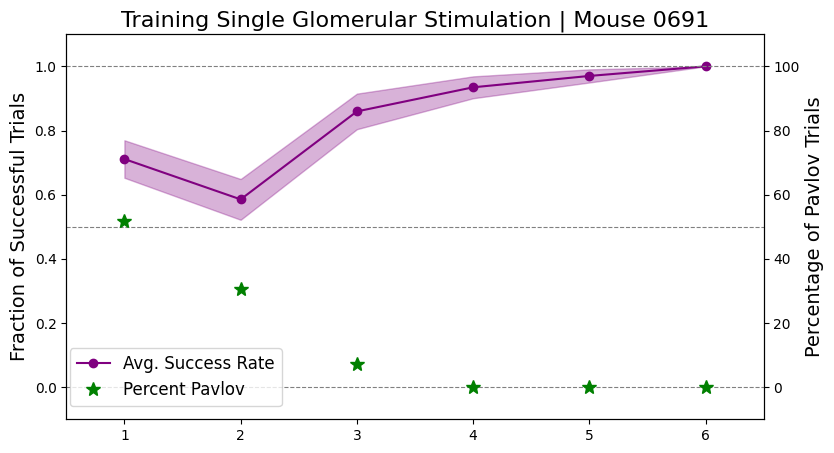

In [19]:
x = np.arange(n_sessions) + 1

fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot Average Success Rate on the left y-axis
line1, = ax1.plot(x, avg_SUCCESS_plot, 'o-', label='Avg. Success Rate', color='purple')
ax1.axhline(y=0.0, color='gray', linestyle='--', linewidth=0.8)
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8)

# Extract the confidence intervals for the average success rate
lower_bounds = confidence_intervals[:, 1]  # Lower bounds
upper_bounds = confidence_intervals[:, 0]  # Upper bounds

# Plot the shaded error region for the confidence interval
ax1.fill_between(x, lower_bounds, upper_bounds, color='purple', alpha=0.3)

# Left y-axis (Fraction of Successful Match Trials)
ax1.set_ylabel('Fraction of Successful Trials', fontsize=14)
ax1.set_ylim(-0.1, 1.1)  # Setting limits from slightly below 0 to slightly above 1
ax1.set_xlim(0.5, n_sessions + 0.5)
ax1.set_xticks(x)

# Create a second y-axis on the right for Percent Pavlov
ax2 = ax1.twinx()
ax2.plot(x, pavlov_percent, 'g*', label='Percent Pavlov', markersize=10)

# Right y-axis (Percentage of Pavlov Trials)
ax2.set_ylabel('Percentage of Pavlov Trials', fontsize=14)
ax2.set_ylim(-10, 110)  # Pavlov percentage range from 0 to 100
ax2.set_yticks(np.arange(0, 101, 20))  # Ticks at 0, 20, 40, 60, 80, 100

# Title and legend
ax1.set_title(f'Training Single Glomerular Stimulation | Mouse {mouse_number}', fontsize=16)

# Add legends for both lines
fig.legend(loc='lower left', bbox_to_anchor=(0.12, 0.12), fontsize='large')

# Display the plot
plt.show()

### Save the produced plots

This code with save the produced plot to a created folder in the **home_directory** which you specified at the beginning of the code. Specifically it will create a new folder in your home directory called _plots_behavior_.

In [20]:
# Save the figure as a .png file in the specified directory
save_directory = os.path.join(home_directory, 'plots_behavior')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the full path for the plot
save_path = os.path.join(save_directory, f'SGS_Training_mouse{mouse_number}.png')

# Save the plot
fig.savefig(save_path, dpi=300)

## THE END